In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltimport 
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP, TrainRNN
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion
from lib.data import TwoStateMNISTData

In [2]:
root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [3]:
#sample n_samples correctly classified examples
def getCorrect(net, data, n_samples=100):
    xs = []
    ys = []

    i = 0
    while i < n_samples:
        d = data.next_batch(batch_size=1)
        x, y = d[0], d[1]
        output = net.eval_forward(*d)
        _, ans = torch.max(output, 1)
        if ans.item() != y.item(): # incorrect
            continue

        xs.append(x)
        ys.append(y)
        i += 1
    return xs, ys

def show_examples(net, xs, ys, n_show=3):
    for x, y in zip(xs[:n_show], ys[:n_show]):
        yhat = net.eval_forward(x, y, [len(x)])
        val, ind = torch.max(yhat, 1)
        
        n_images, _, w_h = x.shape
        print('label: %d, predict: %d, prob: %.2f' % (y.item(), ind.item(), np.exp(val.item())))
        for i in range(n_images):
            plt.subplot(1,3,i+1)
            plt.imshow(x[i].view(28,28).detach().numpy())
        plt.show()

### MLP: sanity check

In [4]:
from lib.model import MLP
net = MLP([784, 300, 10])
savename = 'models/mlp.pth.tar'
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = FlatData(train_set)

trainer = TrainMLP(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 1s|        0.04426|        0.00001|        1.62998
             62|             1%|          0m 2s|        0.03745|        0.00001|        1.23318
             93|             2%|          0m 3s|        0.03771|        0.00003|        1.00512
            124|             3%|          0m 4s|        0.03538|        0.00005|        0.87418
            155|             4%|          0m 5s|        0.03450|        0.00005|        0.78794
            186|             5%|          0m 6s|        0.03450|        0.00004|        0.73063
            217|             6%|          0m 7s|        0.03278|        0.00006|        0.67811
            248|             7%|          0m 8s|        0.03243|        0.00005|        0.65199
            279|             8%|          0m 8s|        0.03165|        0.00005|        0.63766
            310|             9%|        

           2666|            85%|         1m 39s|        0.03724|        0.00006|        0.28651
           2697|            86%|         1m 40s|        0.03737|        0.00006|        0.28474
           2728|            87%|         1m 42s|        0.03749|        0.00006|        0.28321
           2759|            88%|         1m 43s|        0.03751|        0.00006|        0.28168
           2790|            89%|         1m 44s|        0.03754|        0.00006|        0.27991
           2821|            90%|         1m 46s|        0.03766|        0.00006|        0.27865
           2852|            91%|         1m 47s|        0.03761|        0.00006|        0.27755
           2883|            92%|         1m 48s|        0.03764|        0.00006|        0.27629
           2914|            93%|         1m 49s|        0.03767|        0.00006|        0.27499
           2945|            94%|         1m 51s|        0.03775|        0.00006|        0.27359
           2976|            95%|        

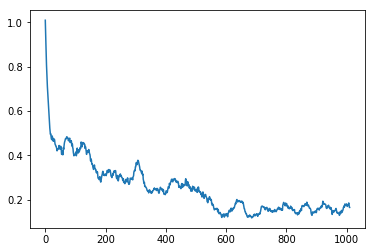

In [5]:
plt.plot(trainer.smooth_loss())
plt.show()

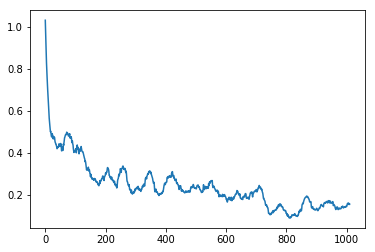

In [125]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 94.50%


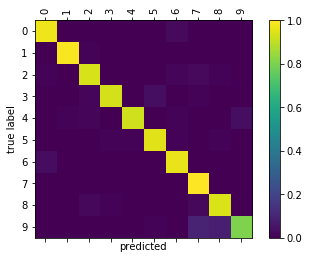

In [6]:
n_categories = 10
evaluation = Evaluation(net, FlatData(test_set))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

# Sequence task: 1-3 mnist digits addition mod 10 (one output for seq)

### 2 layer MLP on the last step

In [18]:
from lib.model import RNN_MLP, RNN_Memoryless
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_MLP(784, n_hidden, n_categories)
savename = 'models/rnn_mlp.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 2s|        0.07014|        0.00001|        2.30425
             62|             1%|          0m 4s|        0.07254|        0.00002|        2.27701
             93|             2%|          0m 7s|        0.08346|        0.00002|        2.25364
            124|             3%|         0m 10s|        0.08656|        0.00006|        2.24153
            155|             4%|         0m 13s|        0.08664|        0.00005|        2.23140
            186|             5%|         0m 16s|        0.08822|        0.00005|        2.23004
            217|             6%|         0m 19s|        0.08908|        0.00007|        2.21650
            248|             7%|         0m 22s|        0.08912|        0.00006|        2.21382
            279|             8%|         0m 25s|        0.09140|        0.00006|        2.21191
            310|             9%|        

           2666|            85%|          4m 2s|        0.09093|        0.00007|        2.15410
           2697|            86%|          4m 4s|        0.09083|        0.00007|        2.15428
           2728|            87%|          4m 7s|        0.09088|        0.00007|        2.15432
           2759|            88%|         4m 10s|        0.09094|        0.00007|        2.15410
           2790|            89%|         4m 13s|        0.09096|        0.00007|        2.15370
           2821|            90%|         4m 17s|        0.09120|        0.00007|        2.15338
           2852|            91%|         4m 19s|        0.09105|        0.00007|        2.15323
           2883|            92%|         4m 21s|        0.09079|        0.00007|        2.15308
           2914|            93%|         4m 25s|        0.09099|        0.00007|        2.15314
           2945|            94%|         4m 28s|        0.09105|        0.00007|        2.15332
           2976|            95%|        

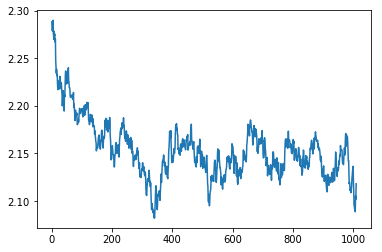

In [19]:
plt.plot(trainer.smooth_loss())
plt.show()

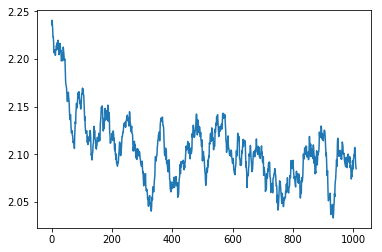

In [127]:
plt.plot(trainer.smooth_loss())
plt.show()

In [ ]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### IMLP

In [20]:
from lib.model import RNN_IMLP

n_hidden = 300
n_categories = 10
net = RNN_IMLP(784, n_hidden, n_categories)
savename = 'models/rnn_imlp.pth.tar'
net.set_max_length(3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 3s|        0.12543|        0.00001|        2.34206
             62|             1%|          0m 7s|        0.12558|        0.00001|        2.18827
             93|             2%|         0m 11s|        0.11898|        0.00002|        2.11158
            124|             3%|         0m 14s|        0.11774|        0.00012|        2.07115
            155|             4%|         0m 18s|        0.11887|        0.00010|        2.03335
            186|             5%|         0m 21s|        0.11547|        0.00008|        2.00396
            217|             6%|         0m 24s|        0.11065|        0.00013|        1.98014
            248|             7%|         0m 26s|        0.10580|        0.00012|        1.96055
            279|             8%|         0m 29s|        0.10622|        0.00011|        1.94702
            310|             9%|        

           2666|            85%|         4m 33s|        0.10246|        0.00014|        1.77124
           2697|            86%|         4m 35s|        0.10217|        0.00014|        1.77102
           2728|            87%|         4m 38s|        0.10212|        0.00014|        1.77101
           2759|            88%|         4m 41s|        0.10211|        0.00014|        1.77024
           2790|            89%|         4m 45s|        0.10246|        0.00014|        1.76968
           2821|            90%|         4m 48s|        0.10235|        0.00014|        1.76992
           2852|            91%|         4m 51s|        0.10229|        0.00014|        1.76960
           2883|            92%|         4m 54s|        0.10224|        0.00014|        1.76897
           2914|            93%|         4m 57s|        0.10226|        0.00014|        1.76777
           2945|            94%|          5m 0s|        0.10199|        0.00014|        1.76711
           2976|            95%|        

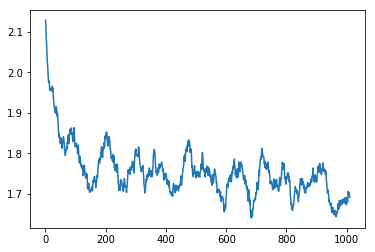

In [21]:
plt.plot(trainer.smooth_loss())
plt.show()

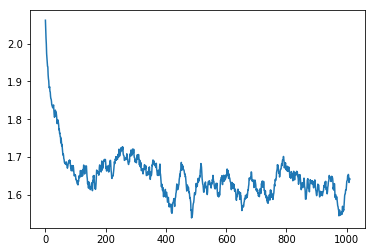

In [129]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.60%


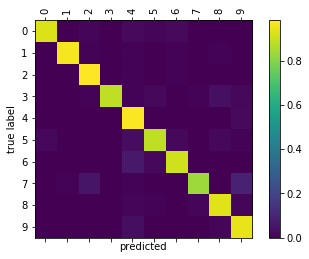

In [73]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### SMLP

In [22]:
from lib.model import RNN_SMLP

n_hidden = 300
n_categories = 10
net = RNN_SMLP(784, n_hidden, n_categories)
savename = 'models/rnn_smlp.pth.tar'
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 2s|        0.09407|        0.00000|        2.32508
             62|             1%|          0m 5s|        0.08815|        0.00001|        2.26203
             93|             2%|          0m 8s|        0.08768|        0.00001|        2.23316
            124|             3%|         0m 11s|        0.09256|        0.00007|        2.19608
            155|             4%|         0m 14s|        0.09563|        0.00006|        2.17501
            186|             5%|         0m 16s|        0.08882|        0.00005|        2.16013
            217|             6%|         0m 18s|        0.08671|        0.00010|        2.16227
            248|             7%|         0m 21s|        0.08791|        0.00009|        2.15587
            279|             8%|         0m 24s|        0.08757|        0.00008|        2.14563
            310|             9%|        

           2666|            85%|         4m 12s|        0.09483|        0.00011|        2.09078
           2697|            86%|         4m 15s|        0.09474|        0.00011|        2.09088
           2728|            87%|         4m 17s|        0.09434|        0.00011|        2.09090
           2759|            88%|         4m 21s|        0.09475|        0.00011|        2.09079
           2790|            89%|         4m 24s|        0.09478|        0.00011|        2.09048
           2821|            90%|         4m 27s|        0.09466|        0.00011|        2.09019
           2852|            91%|         4m 29s|        0.09455|        0.00011|        2.09006
           2883|            92%|         4m 33s|        0.09469|        0.00011|        2.09006
           2914|            93%|         4m 35s|        0.09448|        0.00011|        2.09025
           2945|            94%|         4m 38s|        0.09469|        0.00011|        2.09028
           2976|            95%|        

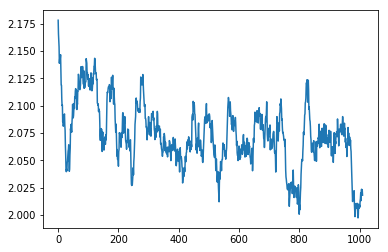

In [23]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.00%


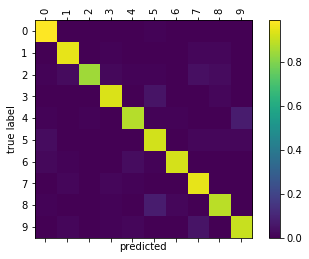

In [24]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Independent LSTM (each time step uses an independent LSTM cell)

In [24]:
from lib.model import RNN_ILSTM

n_hidden = 300
n_categories = 10
net = RNN_ILSTM(784, n_hidden, n_categories)
savename = 'models/rnn_ilstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 6s|        0.21635|        0.00001|        2.25159
             62|             1%|         0m 11s|        0.19222|        0.00001|        2.12292
             93|             2%|         0m 21s|        0.23492|        0.00001|        2.03372
            124|             3%|         0m 29s|        0.23761|        0.00034|        1.97226
            155|             4%|         0m 35s|        0.23184|        0.00027|        1.91884
            186|             5%|         0m 43s|        0.23545|        0.00023|        1.88328
            217|             6%|         0m 50s|        0.23436|        0.00045|        1.86072
            248|             7%|         0m 57s|        0.23307|        0.00039|        1.83285
            279|             8%|          1m 7s|        0.24321|        0.00035|        1.81068
            310|             9%|        

           2666|            85%|         10m 9s|        0.22873|        0.00118|        1.39299
           2697|            86%|        10m 16s|        0.22873|        0.00116|        1.39092
           2728|            87%|        10m 22s|        0.22832|        0.00121|        1.38783
           2759|            88%|        10m 28s|        0.22781|        0.00119|        1.38503
           2790|            89%|        10m 34s|        0.22736|        0.00118|        1.38255
           2821|            90%|        10m 39s|        0.22680|        0.00118|        1.37958
           2852|            91%|        10m 47s|        0.22693|        0.00117|        1.37718
           2883|            92%|        10m 55s|        0.22740|        0.00116|        1.37450
           2914|            93%|         11m 1s|        0.22698|        0.00126|        1.37158
           2945|            94%|         11m 7s|        0.22677|        0.00125|        1.36915
           2976|            95%|        

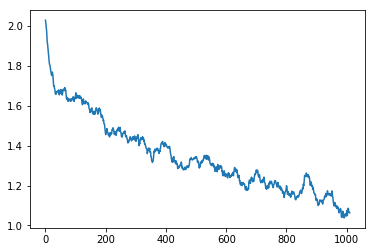

In [ ]:
plt.plot(trainer.smooth_loss())
plt.show()

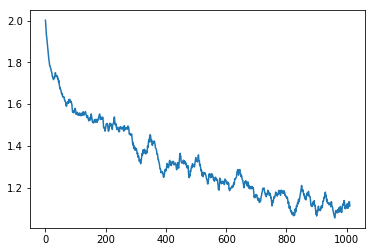

In [133]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.40%


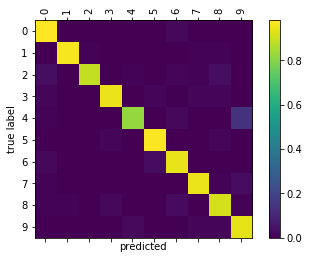

In [38]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Staged LSTM

In [32]:
from lib.model import RNN_SLSTM

n_hidden = 300
n_categories = 10
net = RNN_SLSTM(784, n_hidden, n_categories)
savename = 'models/rnn_slstm.pth.tar'
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_slstm.pth.tar'
=> loaded checkpoint 'models/rnn_slstm.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


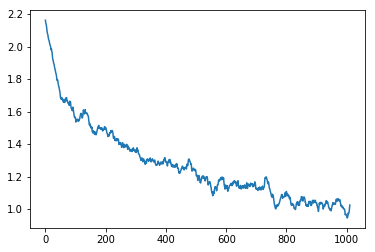

In [33]:
plt.plot(trainer.smooth_loss())
plt.show()

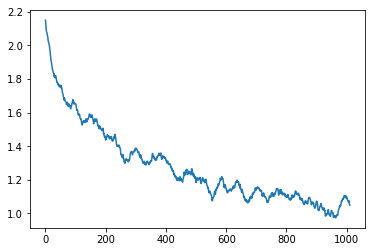

In [135]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.50%


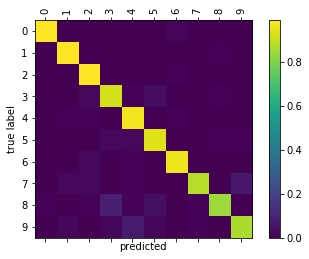

In [57]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### LSTM

In [34]:
from lib.model import RNN_LSTM
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_LSTM(784, n_hidden, n_categories)
savename = 'models/rnn_lstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
             31|             0%|          0m 4s|        0.15331|        0.00001|        2.30409
             62|             1%|         0m 11s|        0.17796|        0.00002|        2.26452
             93|             2%|         0m 15s|        0.17181|        0.00002|        2.24336
            124|             3%|         0m 20s|        0.16518|        0.00013|        2.20227
            155|             4%|         0m 24s|        0.16004|        0.00011|        2.15016
            186|             5%|         0m 27s|        0.14967|        0.00009|        2.09295
            217|             6%|         0m 31s|        0.14573|        0.00016|        2.04531
            248|             7%|         0m 36s|        0.14847|        0.00015|        2.00159


KeyboardInterrupt: 

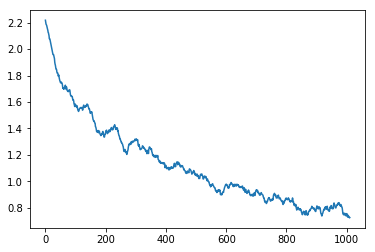

In [191]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.80%


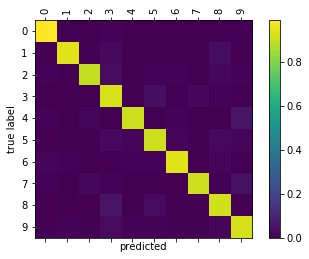

In [157]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

label: 9, predict: 9, prob: 0.70


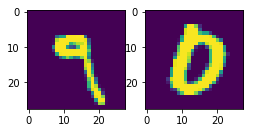

label: 6, predict: 6, prob: 0.44


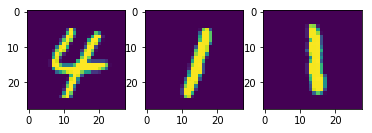

label: 8, predict: 8, prob: 0.23


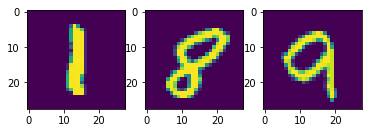

In [27]:
xs, ys = getCorrect(net, MNIST_add_data(test_set, min_length=2, max_length=3))    
show_examples(net, xs, ys)

### proposed methods: Mixture of Weights

$$W_t = \sum_{k=1}^K \lambda^{(k)}_t W^{(k)}$$ 


### lstm mow

In [35]:
from lib.model import RNN_LSTM_MoW
from lib.train import TrainSOMetaRNN

n_hidden = 300
n_categories = 10
net = RNN_LSTM_MoW(784, n_hidden, n_categories)
savename = 'models/rnn_lstm_mow.pth.tar'
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSOMetaRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_lstm_mow.pth.tar'
=> loaded checkpoint 'models/rnn_lstm_mow.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


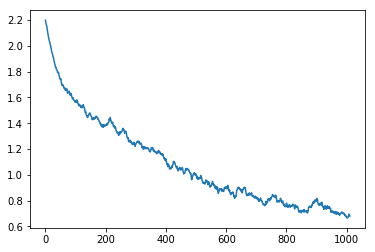

In [36]:
plt.plot(trainer.smooth_loss())
plt.show()

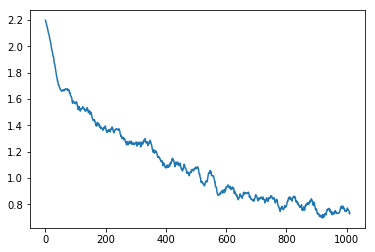

In [139]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 94.10%


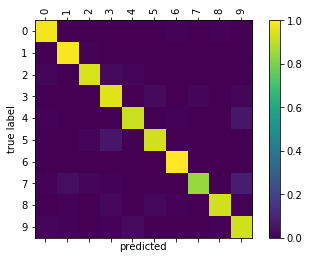

In [141]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

## mlp mow

In [37]:
from lib.model import RNN_MLP_MoW

n_hidden = 300
n_categories = 10
net = RNN_MLP_MoW(784, n_hidden, n_categories)
savename = 'models/rnn_mlp_mow.pth.tar'
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSOMetaRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_mlp_mow.pth.tar'
=> loaded checkpoint 'models/rnn_mlp_mow.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


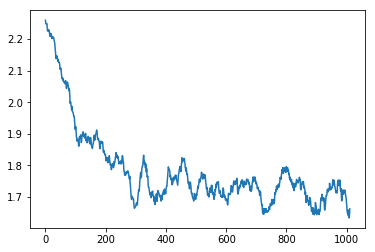

In [38]:
plt.plot(trainer.smooth_loss())
plt.show()

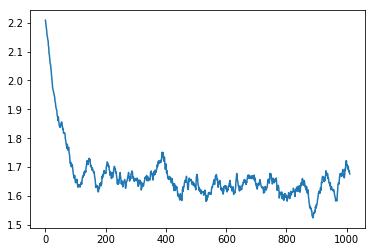

In [141]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.50%


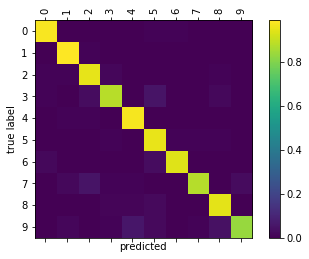

In [179]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

In [142]:
torch.nn.functional.softmax(net.coef, 1)

tensor([[0.8209, 0.1791],
        [0.3022, 0.6978],
        [0.2972, 0.7028]], grad_fn=<SoftmaxBackward>)

## Prediction tasks associated with internal states

Consider the following problem

$\mathcal{S} = \{s1, s2\}$

$\mathcal{X} = \text{MNIST Digits}$

Prediction function $f$ 

$f: x \mapsto x$ if $s=s1$

$f: x \mapsto {10-x} \pmod{10}$ if $s=s2$

State transition is **independent** of covariates at the current time step

$p(s_{t+1} = s1|s_t=s1) = p$

$p(s_{t+1} = s2|s_t=s2) = 1$

$p(s_0=s1) = 1$

In other words, we starts at state $s1$ and transition to $s2$ with probability $(1-p)$, and once we are at $s2$, we never look back.


In [222]:
p = 0.1
n_time_steps = 8

print('p=%.2f' % p)
header = ('t', 'P(s1)', 'P(s2)')
columns = []
columns.append(header)
for i in range(n_time_steps):
    columns.append((i, p**i, 1-p**i))
    
def print_table(columns):
    def format(x):
        if type(x) is float:
            x_tr = "%.3f" % x
        else:
            x_tr = str(x)
        return "%10s" % x_tr

    to_print = ""
    for r in zip(*columns):
        r = map(format, r)
        to_print += " ".join(r)
        to_print += "\n"
    print(to_print)

print_table(columns)

p=0.10
         t          0          1          2          3          4          5          6          7
     P(s1)      1.000      0.100      0.010      0.001      0.000      0.000      0.000      0.000
     P(s2)      0.000      0.900      0.990      0.999      1.000      1.000      1.000      1.000

